### Notebook created by _Bruna Faria._

###### Experience with ML/DL and exploring data. PhD student in Computational and Data Science and Engineering (Skoltech).


This Notebook is divided into 3 parts:

* Part 1 : getting sub-images from an input image using selective search;
* Part 2 : classifying sub-images with pre-trained models;
* Part 3 : getting sub-images from an input image using contours approach.

# Part 1


* Basic approach to get sub-images from an input image file using selective search approach.

### 1) Importing essential libraries for the first part:

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img

### 2) Implementing basic functions:

In [2]:
#generate subimages from bounding boxes - Selective Search
def selective_search(image, method='quality'):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    
    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else: 
        ss.switchToSelectiveSearchQuality()
        
    bounding = ss.process()
    print(bounding.shape)
    
    return bounding

#plotting bounding boxes examples
def plot_boxes(image, bounding, k=10):
    rand = bounding[np.random.randint(low = 0, high = bounding.shape[0], size = k),]
    output = image.copy()
    for (a, b, w, h) in bounding[0:100,]:
        color = [np.random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(output, (a, b), (a + w, b + h), color, 2)

    plt.imshow(output)

#extracting region of interest, convert and resize to 224x224 (required input), also can save images
def get_subimages(image, bounding, save=False):
    subimgs = [] #proposal sub-images
    boxes = [] #sub-images boxes
    H, W = image.shape[:2] #getting height and width
    for ind,(x, y, w, h) in enumerate(bounding):
        if w/float(W) < 0.1 or h/float(H) < 0.1: #filtering sub-images
            continue

        roi = image[y:y + h, x:x + w]        
        #roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (224, 224))
        subimgs.append(roi)
        boxes.append((x, y, w, h))
        if save == True:
            try: 
                os.mkdir('selsearch')
            except: 
                pass
            
            cv2.imwrite('selsearch/subimg{}.jpg'.format(ind), roi)
       
    return subimgs, boxes     

### 3) Loading an image:

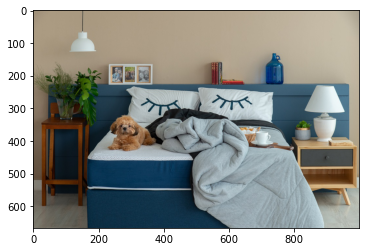

In [3]:
#loading the input image
image = img.imread('imgs/image00.jpg') #array

#displaying the input image
plt.imshow(image)
plt.show()

### 4) Applying selective search for the input image and getting sub-images

In [4]:
%%time
#generating bounding boxes
bounding = selective_search(image)

(14907, 4)
Wall time: 1min 31s


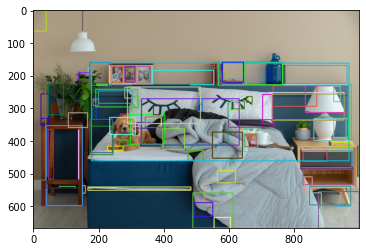

In [5]:
plot_boxes(image, bounding)

In [6]:
%%time
#selsearch folder will be created if save is True!
subimages, boxes = get_subimages(image, bounding, save=True)
subimages = np.array(subimages) #convert list to array
print("sub-images shape: {}".format(subimages.shape))

sub-images shape: (6361, 224, 224, 3)
Wall time: 1min 19s


> **Note the number of sub-images obtained in this last step**

In [7]:
#All images from selective search was saved into selsearch folder
len(os.listdir('selsearch'))

6361

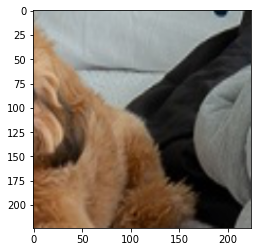

In [8]:
plt.imshow(subimages[0])

# Part 2

* Classifying sub-images (objects) with pre-trained models

### 5) Importing essential libraries for this second part

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.applications.vgg19 import preprocess_input, decode_predictions, VGG19
from keras.applications import ResNet50, imagenet_utils
from keras.applications.resnet50 import preprocess_input
from imutils.object_detection import non_max_suppression

### 6) Implementing functions to load input images for model predict

In [10]:
#For images from subimages array
def get_input(image):
    img_ = img_to_array(image)
    img_ = img_.reshape((1, 224, 224, 3))
    img_ = preprocess_input(img_)
    return img_
    
#For images from files in subs folder as jpg
def get_input_jpg(image):
    img_ = keras.preprocessing.image.load_img(image, target_size=(224, 224))
    img_array = img_to_array(img_)
    img_array = img_array.reshape((1, 224, 224, 3))
    img_input = preprocess_input(img_array)
    return img_, img_input

#classifing each subimage
def get_predictions(subimgs, boxes, model, cutoff=0.7, save=False):
    labels = {}
    pred_imgs = []
    for ind,simg in enumerate(subimgs):
        img = get_input(simg)
        pred = model.predict(img)
        pred = imagenet_utils.decode_predictions(pred, top=1)
        imagenetID, label, prob = pred[0][0] #pred information for the current sub-image
        if prob >= cutoff: # filterring according to cutoff probability 
            x, y, w, h = boxes[ind]
            box = (x, y, x+w, y+h)
            L = labels.get(label, [])
            L.append((prob, box))
            labels[label] = L
            pred_imgs.append(simg)
            
            if save == True:
                try: 
                    os.mkdir('filtered')
                except: 
                    pass
            
                cv2.imwrite('filtered/filter{}.jpg'.format(ind), simg)
            
    return labels, pred_imgs

### 7) Loading pre-trained models

In [11]:
model_vgg = VGG19()
model_net = ResNet50()

### 8) Basic example of image classification

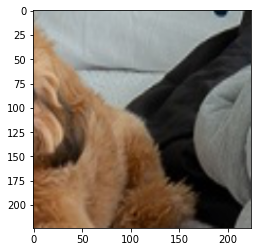

[[('n02098105', 'soft-coated_wheaten_terrier', 0.20228274), ('n02113712', 'miniature_poodle', 0.14551729), ('n02093991', 'Irish_terrier', 0.1040119), ('n02113624', 'toy_poodle', 0.08883731), ('n02099601', 'golden_retriever', 0.070151746), ('n02097474', 'Tibetan_terrier', 0.034526754), ('n02113799', 'standard_poodle', 0.033342566), ('n02086079', 'Pekinese', 0.028587539), ('n02094114', 'Norfolk_terrier', 0.025982376), ('n02098413', 'Lhasa', 0.024273291)]]
Wall time: 974 ms


In [15]:
%%time
#Classification using vgg
img = get_input(subimages[0])
yhat = model_vgg.predict(img)
label = decode_predictions(yhat, top = 10)
plt.imshow(subimages[0])
plt.show()
print(label)

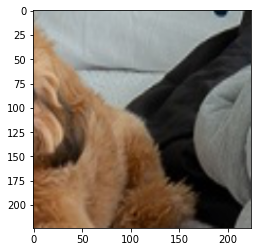

[[('n02113712', 'miniature_poodle', 0.2810127), ('n02097474', 'Tibetan_terrier', 0.25992277), ('n02098105', 'soft-coated_wheaten_terrier', 0.13032374), ('n02113624', 'toy_poodle', 0.12995836), ('n02098413', 'Lhasa', 0.055242203), ('n02086240', 'Shih-Tzu', 0.054048218), ('n02096437', 'Dandie_Dinmont', 0.014079153), ('n02086079', 'Pekinese', 0.0130354995), ('n02113799', 'standard_poodle', 0.009957028), ('n02093991', 'Irish_terrier', 0.009271628)]]
Wall time: 2.24 s


In [16]:
%%time
img = get_input(subimages[0])
yhat = model_net.predict(img)
label = decode_predictions(yhat, top = 10)
plt.imshow(subimages[0])
plt.show()
print(label)

### 9) Refined method to classify sub-images

In [12]:
%%time
#This step will classify all images into selsearch folder and filter the 
#prediction according to cutoff saving that one into new folder filtered
#example: cutoff = 0.8 means just images classified with probability >= 0.8 are returned.
#model_vgg or model_net can be used and compared to each other!

labels, pred_filtered = get_predictions(subimages,boxes,model_vgg, cutoff=0.8, save=True)

Wall time: 32min 59s


In [14]:
len(os.listdir('filtered'))

139

object classified as table_lamp with probability 0.8816952109336853


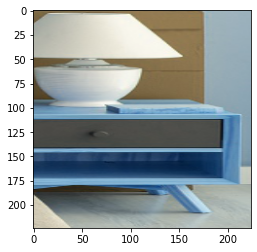

object classified as bath_towel with probability 0.894347071647644


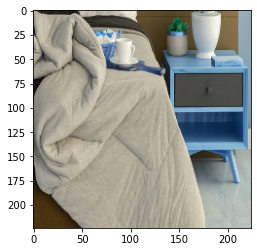

object classified as Afghan_hound with probability 0.848609209060669


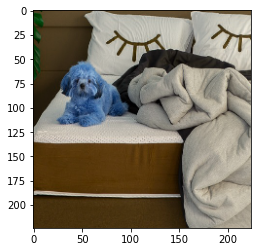

In [47]:
#Displaying sub-images with max probability for each key from labels dictionary
for key in labels.keys():
    prob = []
    for ind,value in enumerate(labels[key]):
        prob.append(value[0])
    
    mprob = max(prob)
    idx = prob.index(mprob)
    x, y, w, h = labels[key][idx][1]
    roi = image[y:y + h, x:x + w]             
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, (224, 224))
    
    print('object classified as {} with probability {}'.format(key, mprob))
    plt.imshow(roi)
    plt.show()

### 10) Loop implementation to classify several sub-images directly from _selsearch_ folder

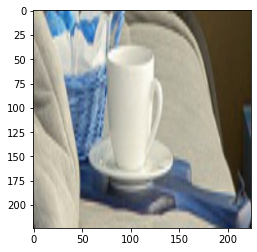

[[('n03887697', 'paper_towel', 0.13143776), ('n15075141', 'toilet_tissue', 0.055645175), ('n03630383', 'lab_coat', 0.047959555), ('n04560804', 'water_jug', 0.03233051), ('n03476991', 'hair_spray', 0.03067404), ('n03825788', 'nipple', 0.023895938), ('n04033901', 'quill', 0.023772027), ('n02948072', 'candle', 0.018911663), ('n07932039', 'eggnog', 0.017829685), ('n03063689', 'coffeepot', 0.01663836)]]


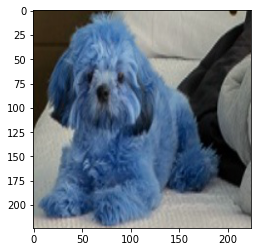

[[('n02085936', 'Maltese_dog', 0.53008366), ('n02098413', 'Lhasa', 0.20946398), ('n02097474', 'Tibetan_terrier', 0.07964646), ('n02105641', 'Old_English_sheepdog', 0.068052046), ('n02086240', 'Shih-Tzu', 0.05333922), ('n02095889', 'Sealyham_terrier', 0.011778963), ('n02113624', 'toy_poodle', 0.00844888), ('n02113712', 'miniature_poodle', 0.0056351763), ('n02096437', 'Dandie_Dinmont', 0.0045701577), ('n02086079', 'Pekinese', 0.002636413)]]


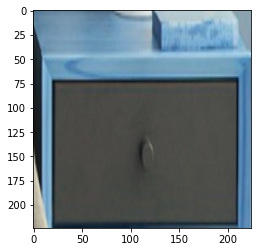

[[('n04152593', 'screen', 0.108109646), ('n03782006', 'monitor', 0.09627376), ('n03180011', 'desktop_computer', 0.06229176), ('n04404412', 'television', 0.059823167), ('n03337140', 'file', 0.042997777), ('n03691459', 'loudspeaker', 0.03508409), ('n03584254', 'iPod', 0.032914855), ('n03085013', 'computer_keyboard', 0.02581598), ('n04125021', 'safe', 0.024727812), ('n03832673', 'notebook', 0.02172281)]]


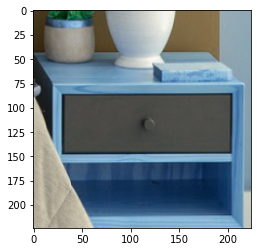

[[('n03903868', 'pedestal', 0.06712468), ('n04380533', 'table_lamp', 0.056758165), ('n03887697', 'paper_towel', 0.043437347), ('n04553703', 'washbasin', 0.017346337), ('n04404412', 'television', 0.0152543215), ('n03337140', 'file', 0.015236053), ('n04254120', 'soap_dispenser', 0.0127415005), ('n04522168', 'vase', 0.012179416), ('n03290653', 'entertainment_center', 0.012176698), ('n15075141', 'toilet_tissue', 0.011429655)]]


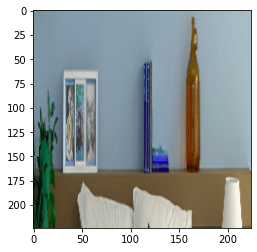

[[('n03930313', 'picket_fence', 0.2453314), ('n03876231', 'paintbrush', 0.12801944), ('n02948072', 'candle', 0.080653735), ('n02699494', 'altar', 0.061212856), ('n03887697', 'paper_towel', 0.06087767), ('n03201208', 'dining_table', 0.033444073), ('n03131574', 'crib', 0.023569318), ('n04040759', 'radiator', 0.02121279), ('n03388549', 'four-poster', 0.02010158), ('n04367480', 'swab', 0.019856764)]]


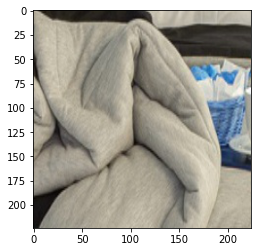

[[('n03404251', 'fur_coat', 0.17690074), ('n04599235', 'wool', 0.11123583), ('n04370456', 'sweatshirt', 0.049322013), ('n02808304', 'bath_towel', 0.045980364), ('n04325704', 'stole', 0.03349864), ('n02963159', 'cardigan', 0.030266732), ('n04350905', 'suit', 0.027360566), ('n03188531', 'diaper', 0.02350151), ('n03877472', 'pajama', 0.023254517), ('n04399382', 'teddy', 0.020984655)]]


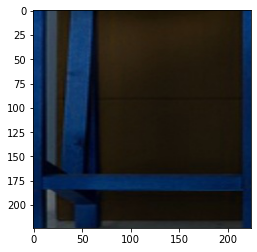

[[('n04590129', 'window_shade', 0.10053126), ('n02977058', 'cash_machine', 0.05468655), ('n04239074', 'sliding_door', 0.04945036), ('n02788148', 'bannister', 0.042159345), ('n04201297', 'shoji', 0.0331644), ('n04005630', 'prison', 0.025908133), ('n03782006', 'monitor', 0.025722504), ('n04404412', 'television', 0.023567801), ('n04501370', 'turnstile', 0.022997988), ('n02870880', 'bookcase', 0.019803625)]]


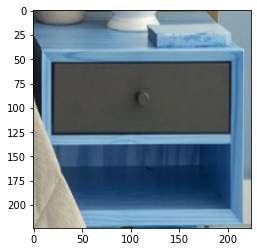

[[('n04380533', 'table_lamp', 0.04344885), ('n03180011', 'desktop_computer', 0.038038388), ('n03832673', 'notebook', 0.034514923), ('n03337140', 'file', 0.034466505), ('n04152593', 'screen', 0.030641187), ('n03179701', 'desk', 0.030018242), ('n03085013', 'computer_keyboard', 0.02753388), ('n03782006', 'monitor', 0.027355963), ('n03290653', 'entertainment_center', 0.024914505), ('n04404412', 'television', 0.021838538)]]


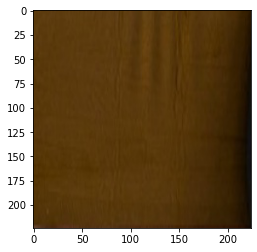

[[('n04550184', 'wardrobe', 0.11198903), ('n03637318', 'lampshade', 0.099330105), ('n04590129', 'window_shade', 0.06089667), ('n04209239', 'shower_curtain', 0.042921204), ('n04201297', 'shoji', 0.029132636), ('n04418357', 'theater_curtain', 0.022202298), ('n03788365', 'mosquito_net', 0.021925727), ('n04239074', 'sliding_door', 0.016126081), ('n04380533', 'table_lamp', 0.015209199), ('n04548280', 'wall_clock', 0.013401619)]]


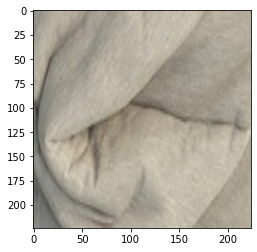

[[('n04370456', 'sweatshirt', 0.20581186), ('n04599235', 'wool', 0.1155327), ('n02808304', 'bath_towel', 0.10100056), ('n02092339', 'Weimaraner', 0.090529196), ('n03404251', 'fur_coat', 0.049442396), ('n03188531', 'diaper', 0.018400174), ('n04525038', 'velvet', 0.013518115), ('n02786058', 'Band_Aid', 0.0133902235), ('n02110958', 'pug', 0.012861315), ('n02074367', 'dugong', 0.0081321485)]]


In [50]:
#1) using VGG model
#As there are a lot of images, I decided choice some random sub-images to classify
random_imgs = np.random.choice(os.listdir('selsearch'), 10) #10 images as example
for i in random_imgs:
    img, img_input = get_input_jpg('selsearch/'+i)
    yhat = model_vgg.predict(img_input)
    label = decode_predictions(yhat, top = 10)
    plt.imshow(img)
    plt.show()
    print(label)

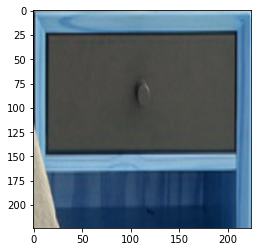

[[('n03337140', 'file', 0.20777564), ('n04404412', 'television', 0.17169297), ('n03290653', 'entertainment_center', 0.08108233), ('n03782006', 'monitor', 0.0462535), ('n04152593', 'screen', 0.035184298), ('n04125021', 'safe', 0.023750389), ('n03691459', 'loudspeaker', 0.021466307), ('n03197337', 'digital_watch', 0.018821757), ('n03529860', 'home_theater', 0.018069988), ('n02092339', 'Weimaraner', 0.014054581)]]


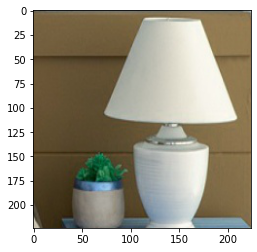

[[('n04380533', 'table_lamp', 0.7796951), ('n03637318', 'lampshade', 0.18704368), ('n03775546', 'mixing_bowl', 0.002825634), ('n04286575', 'spotlight', 0.0026379686), ('n03337140', 'file', 0.0025348673), ('n02971356', 'carton', 0.0011968585), ('n04447861', 'toilet_seat', 0.0009825861), ('n03179701', 'desk', 0.0009518366), ('n03887697', 'paper_towel', 0.0007816411), ('n02870880', 'bookcase', 0.0007756482)]]


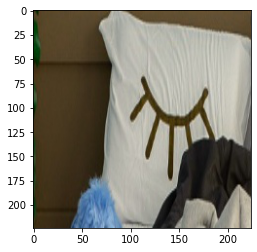

[[('n03866082', 'overskirt', 0.26006657), ('n03482405', 'hamper', 0.15226205), ('n02730930', 'apron', 0.14644966), ('n03938244', 'pillow', 0.07014358), ('n04532106', 'vestment', 0.047557123), ('n03125729', 'cradle', 0.031108487), ('n03450230', 'gown', 0.024602033), ('n03249569', 'drum', 0.01776259), ('n02804414', 'bassinet', 0.01752669), ('n03534580', 'hoopskirt', 0.014528024)]]


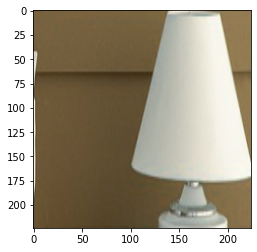

[[('n04380533', 'table_lamp', 0.6947053), ('n03637318', 'lampshade', 0.2963909), ('n04286575', 'spotlight', 0.001710736), ('n03691459', 'loudspeaker', 0.00055236684), ('n03903868', 'pedestal', 0.0004868887), ('n03887697', 'paper_towel', 0.0003501399), ('n04254120', 'soap_dispenser', 0.0002444016), ('n03534580', 'hoopskirt', 0.00019284361), ('n02971356', 'carton', 0.00018783857), ('n03690938', 'lotion', 0.00017554758)]]


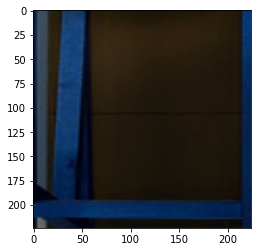

[[('n02977058', 'cash_machine', 0.14331874), ('n04418357', 'theater_curtain', 0.056698393), ('n03529860', 'home_theater', 0.054233763), ('n04239074', 'sliding_door', 0.052864466), ('n03888605', 'parallel_bars', 0.04365407), ('n03290653', 'entertainment_center', 0.030973295), ('n04125021', 'safe', 0.024254482), ('n04005630', 'prison', 0.024119036), ('n04590129', 'window_shade', 0.02069027), ('n04201297', 'shoji', 0.015753603)]]


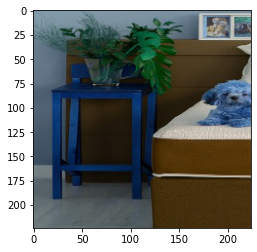

[[('n03014705', 'chest', 0.12087135), ('n03337140', 'file', 0.0928361), ('n04344873', 'studio_couch', 0.08946421), ('n02870880', 'bookcase', 0.07499421), ('n04550184', 'wardrobe', 0.06433991), ('n03179701', 'desk', 0.061448872), ('n03018349', 'china_cabinet', 0.060141098), ('n04493381', 'tub', 0.05055519), ('n03131574', 'crib', 0.029974174), ('n04239074', 'sliding_door', 0.029700099)]]


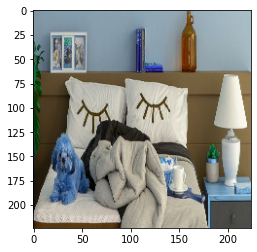

[[('n02808304', 'bath_towel', 0.20174718), ('n04344873', 'studio_couch', 0.19760385), ('n04033995', 'quilt', 0.12673667), ('n03131574', 'crib', 0.10466396), ('n04550184', 'wardrobe', 0.059145853), ('n04380533', 'table_lamp', 0.04406082), ('n03637318', 'lampshade', 0.024430402), ('n02870880', 'bookcase', 0.023689102), ('n04367480', 'swab', 0.020450147), ('n03125729', 'cradle', 0.01850382)]]


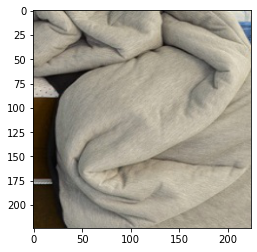

[[('n03404251', 'fur_coat', 0.2158468), ('n04599235', 'wool', 0.17752822), ('n02808304', 'bath_towel', 0.16022424), ('n03627232', 'knot', 0.11770829), ('n04370456', 'sweatshirt', 0.092255495), ('n02092339', 'Weimaraner', 0.021264851), ('n03188531', 'diaper', 0.020263119), ('n03903868', 'pedestal', 0.01631355), ('n04033995', 'quilt', 0.01577489), ('n07860988', 'dough', 0.01385906)]]


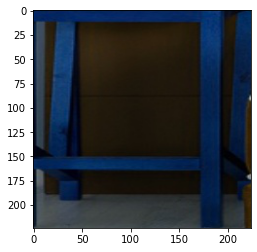

[[('n04005630', 'prison', 0.16625272), ('n03131574', 'crib', 0.109526746), ('n03888605', 'parallel_bars', 0.10678095), ('n04099969', 'rocking_chair', 0.092710815), ('n04239074', 'sliding_door', 0.047293965), ('n04501370', 'turnstile', 0.038538083), ('n03535780', 'horizontal_bar', 0.03098458), ('n03384352', 'forklift', 0.028368287), ('n04613696', 'yurt', 0.014343413), ('n02788148', 'bannister', 0.01412663)]]


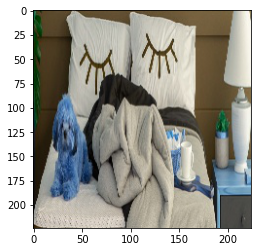

[[('n02808304', 'bath_towel', 0.65168905), ('n04367480', 'swab', 0.21347111), ('n04550184', 'wardrobe', 0.06315974), ('n04209239', 'shower_curtain', 0.010061668), ('n03404251', 'fur_coat', 0.009048911), ('n03485794', 'handkerchief', 0.008330032), ('n03637318', 'lampshade', 0.006503021), ('n04325704', 'stole', 0.005716249), ('n04599235', 'wool', 0.0045526954), ('n02804414', 'bassinet', 0.0029532711)]]


In [51]:
#2) using ResNet model
#As there are a lot of images, I decided choice some random sub-images to classify
random_imgs = np.random.choice(os.listdir('selsearch'), 10) #10 images as example!
for i in random_imgs:
    img, img_input = get_input_jpg('selsearch/'+i)
    yhat = model_net.predict(img_input)
    label = decode_predictions(yhat, top = 10)
    plt.imshow(img)
    plt.show()
    print(label)

# Part 3


* Basic approach to get sub-images from an input image file using contours approach.

### A) Implementing basic functions

In [52]:
#generate subimages from contours
def get_contours(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)   
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image = cv2.drawContours(image, contours, -1, (0, 255, 0), 10)
    plt.imshow(image)
    plt.show()
    plt.imshow(binary, cmap="gray")
    plt.show()
    return contours, hierarchy

def get_imgcontours(contours, save=False):    
    subimgs = [] #sub-images from contours
    boxes = [] #sub-images boxes
    for i in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[i])
        roi = image[y:y+h, x:x+w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (224, 224))
        subimgs.append(roi)
        boxes.append((x, y, w, h))
        if save == True:
            try: 
                os.mkdir('contours')
            except: 
                pass
            
            cv2.imwrite('contours/obj{}.jpg'.format(i), roi)
        
    return subimgs, boxes    

### B) Loading the input image

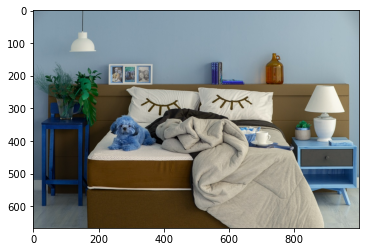

In [53]:
#loading the input image
image = cv2.imread('imgs/image00.jpg')

#displaying the input image
plt.imshow(image)

### C) Getting contours from the input image and saving sub-images

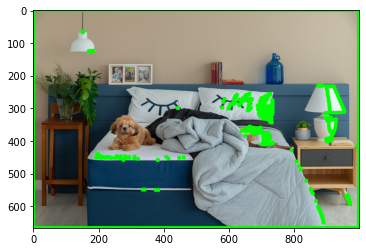

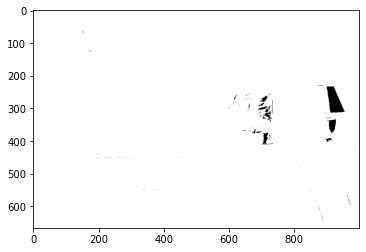

In [54]:
#getting contours
contours, hierarchy = get_contours(image)

In [55]:
%%time
subimages1, boxes1 = get_imgcontours(contours, save=True)
subimages1 = np.array(subimages1) #convert list to array
print("sub-images shape: {}".format(subimages1.shape))

sub-images shape: (221, 224, 224, 3)
Wall time: 1.59 s


In [61]:
len(os.listdir('contours'))

221

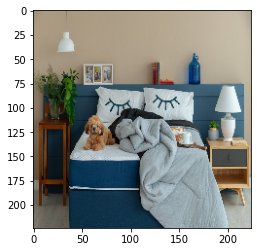

In [56]:
#displaying the first sub-image from subimages as example
plt.imshow(subimages1[0])

### D) Classifying the images generated from contours

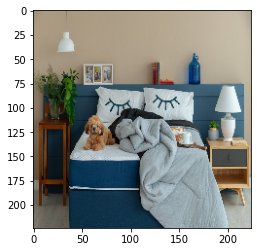

[[('n02804414', 'bassinet', 0.26604688), ('n02808304', 'bath_towel', 0.13815051), ('n04344873', 'studio_couch', 0.06736567), ('n03125729', 'cradle', 0.057875346), ('n03131574', 'crib', 0.04377986), ('n03045698', 'cloak', 0.0435289), ('n04033995', 'quilt', 0.021369873), ('n04235860', 'sleeping_bag', 0.015591472), ('n02699494', 'altar', 0.015100507), ('n03887697', 'paper_towel', 0.012804481)]]
Wall time: 830 ms


In [57]:
%%time
#Classification using vgg
img = get_input(subimages1[0])
yhat = model_vgg.predict(img)
label = decode_predictions(yhat, top = 10)
plt.imshow(subimages1[0])
plt.show()
print(label)

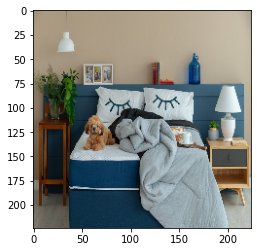

[[('n02808304', 'bath_towel', 0.46040857), ('n03026506', 'Christmas_stocking', 0.27420193), ('n04399382', 'teddy', 0.03743236), ('n04344873', 'studio_couch', 0.026141148), ('n03131574', 'crib', 0.025172323), ('n03179701', 'desk', 0.019439386), ('n02094114', 'Norfolk_terrier', 0.01398393), ('n04550184', 'wardrobe', 0.013412914), ('n02804414', 'bassinet', 0.011435195), ('n04235860', 'sleeping_bag', 0.0101248305)]]
Wall time: 449 ms


In [58]:
%%time
#Classification using resnet
img = get_input(subimages1[0])
yhat = model_net.predict(img)
label = decode_predictions(yhat, top = 10)
plt.imshow(subimages1[0])
plt.show()
print(label)

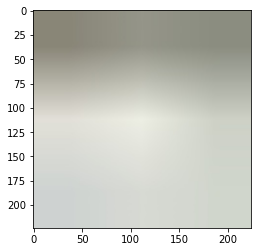

[[('n03041632', 'cleaver', 0.052414395), ('n03777754', 'modem', 0.03444377), ('n04376876', 'syringe', 0.024443943), ('n03207941', 'dishwasher', 0.021218672), ('n04270147', 'spatula', 0.021131806), ('n02783161', 'ballpoint', 0.019504176), ('n04118776', 'rule', 0.019354563), ('n03633091', 'ladle', 0.016625067), ('n03832673', 'notebook', 0.013989233), ('n04372370', 'switch', 0.013392602)]]


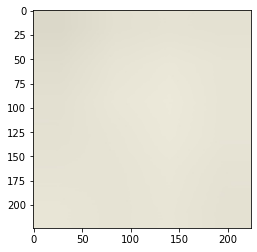

[[('n04376876', 'syringe', 0.018190678), ('n03291819', 'envelope', 0.013139891), ('n03041632', 'cleaver', 0.0127515765), ('n02783161', 'ballpoint', 0.010576472), ('n03658185', 'letter_opener', 0.010169522), ('n03729826', 'matchstick', 0.009778467), ('n04019541', 'puck', 0.009093578), ('n03804744', 'nail', 0.00907251), ('n04153751', 'screw', 0.008997658), ('n04116512', 'rubber_eraser', 0.0086713685)]]


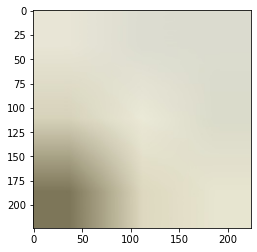

[[('n03476991', 'hair_spray', 0.022403888), ('n03916031', 'perfume', 0.018634377), ('n03937543', 'pill_bottle', 0.017227435), ('n03729826', 'matchstick', 0.016372155), ('n03690938', 'lotion', 0.016156614), ('n07892512', 'red_wine', 0.014358343), ('n03666591', 'lighter', 0.014351217), ('n04070727', 'refrigerator', 0.013942899), ('n04254120', 'soap_dispenser', 0.013409638), ('n04357314', 'sunscreen', 0.013068387)]]


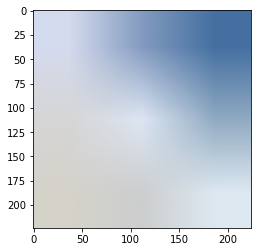

[[('n09288635', 'geyser', 0.022428885), ('n03888257', 'parachute', 0.0220158), ('n04592741', 'wing', 0.0130295055), ('n03729826', 'matchstick', 0.012932073), ('n02814860', 'beacon', 0.01198121), ('n01608432', 'kite', 0.0118542025), ('n03937543', 'pill_bottle', 0.0111031), ('n03804744', 'nail', 0.01081804), ('n03355925', 'flagpole', 0.009318345), ('n03532672', 'hook', 0.008069718)]]


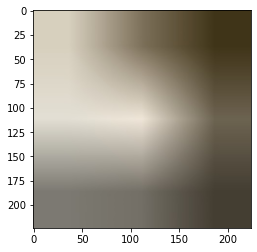

[[('n04286575', 'spotlight', 0.056898396), ('n03476991', 'hair_spray', 0.052785642), ('n03690938', 'lotion', 0.051281817), ('n03937543', 'pill_bottle', 0.046571016), ('n15075141', 'toilet_tissue', 0.04091273), ('n04254120', 'soap_dispenser', 0.03663066), ('n04380533', 'table_lamp', 0.03125138), ('n03637318', 'lampshade', 0.027789922), ('n03916031', 'perfume', 0.023427363), ('n04372370', 'switch', 0.018934242)]]


In [59]:
#1) using VGG model
#As there are a lot of images, I decided choice some random sub-images to classify
random_imgs = np.random.choice(os.listdir('contours'), 5) #just 6 images
for i in random_imgs:
    img, img_input = get_input_jpg('contours/'+i)
    yhat = model_vgg.predict(img_input)
    label = decode_predictions(yhat, top = 10)
    plt.imshow(img)
    plt.show()
    print(label)

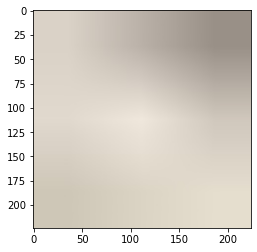

[[('n03207941', 'dishwasher', 0.37576786), ('n03041632', 'cleaver', 0.1617141), ('n04357314', 'sunscreen', 0.10771876), ('n03476991', 'hair_spray', 0.09193828), ('n03690938', 'lotion', 0.027608946), ('n04254120', 'soap_dispenser', 0.018154265), ('n03764736', 'milk_can', 0.014599762), ('n04270147', 'spatula', 0.013742664), ('n04070727', 'refrigerator', 0.012090085), ('n03843555', 'oil_filter', 0.011853189)]]


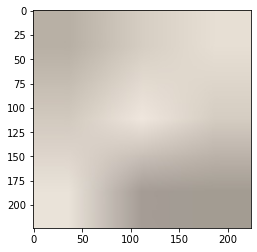

[[('n04357314', 'sunscreen', 0.16131581), ('n03207941', 'dishwasher', 0.11859591), ('n03041632', 'cleaver', 0.10116879), ('n03764736', 'milk_can', 0.08437283), ('n03476991', 'hair_spray', 0.06332608), ('n02783161', 'ballpoint', 0.03850473), ('n03690938', 'lotion', 0.03745474), ('n03314780', 'face_powder', 0.022312207), ('n03903868', 'pedestal', 0.021151446), ('n04254120', 'soap_dispenser', 0.0188333)]]


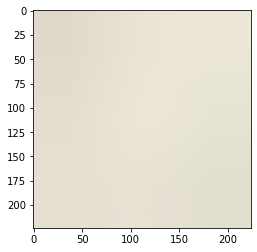

[[('n03207941', 'dishwasher', 0.1474483), ('n04554684', 'washer', 0.14181033), ('n04070727', 'refrigerator', 0.08666555), ('n03291819', 'envelope', 0.025439149), ('n07930864', 'cup', 0.016449306), ('n03832673', 'notebook', 0.013580394), ('n02747177', 'ashcan', 0.012701295), ('n04372370', 'switch', 0.012158321), ('n03777754', 'modem', 0.012145329), ('n03041632', 'cleaver', 0.011396909)]]


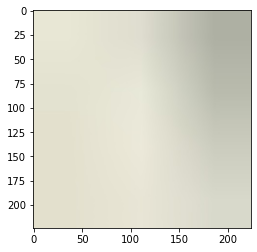

[[('n03207941', 'dishwasher', 0.6005283), ('n04070727', 'refrigerator', 0.057884768), ('n04554684', 'washer', 0.051108934), ('n04357314', 'sunscreen', 0.039732866), ('n04254120', 'soap_dispenser', 0.028474279), ('n02747177', 'ashcan', 0.022058854), ('n03476991', 'hair_spray', 0.017312236), ('n03041632', 'cleaver', 0.010128533), ('n03690938', 'lotion', 0.008332187), ('n03843555', 'oil_filter', 0.0077848765)]]


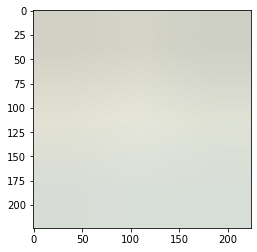

[[('n03207941', 'dishwasher', 0.08690481), ('n03291819', 'envelope', 0.049257), ('n03041632', 'cleaver', 0.042943034), ('n03532672', 'hook', 0.024042957), ('n04070727', 'refrigerator', 0.020832703), ('n04554684', 'washer', 0.01464423), ('n03777754', 'modem', 0.012188058), ('n02783161', 'ballpoint', 0.011406124), ('n03916031', 'perfume', 0.011371707), ('n03876231', 'paintbrush', 0.011148605)]]


In [60]:
#2) using ResNet model
#As there are a lot of images, I decided choice some random sub-images to classify
random_imgs = np.random.choice(os.listdir('contours'), 5) #just 6 images
for i in random_imgs:
    img, img_input = get_input_jpg('contours/'+i)
    yhat = model_net.predict(img_input)
    label = decode_predictions(yhat, top = 10)
    plt.imshow(img)
    plt.show()
    print(label)